# **This notebook aims to study interpretability methods for Survival ML**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Standard ML import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import optuna

# Survival Analysis tools

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc,concordance_index_ipcw, integrated_brier_score
from sksurv.datasets import get_x_y

# Interpretability tools
import shap
import lime.lime_tabular
from survlimepy import SurvLimeExplainer

# **Read and processing**

In [11]:
data_rea = pd.read_csv("readmission.csv")
data_rea.head()

,id,enum,t.start,t.stop,time,event,chemo,sex,dukes,charlson,death
0,1,1,0,24,24,1,Treated,Female,D,3,0
1,1,2,24,457,433,1,Treated,Female,D,0,0
2,1,3,457,1037,580,0,Treated,Female,D,0,0
3,2,1,0,489,489,1,NonTreated,Male,C,0,0
4,2,2,489,1182,693,0,NonTreated,Male,C,0,0


In [12]:
# Keep only the last admission for each patient
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_filtred.head()

,id,enum,t.start,t.stop,time,event,chemo,sex,dukes,charlson,death
0,1,3,457,1037,580,0,Treated,Female,D,0,0
1,2,2,489,1182,693,0,NonTreated,Male,C,0,0
2,3,2,15,783,768,0,NonTreated,Male,C,3,1
3,4,5,686,2048,1362,0,Treated,Female,A-B,0,0
4,5,2,1134,1144,10,0,NonTreated,Female,C,3,0


In [15]:
# One-hot encoding
categorial_columns = ['sex', 'chemo', 'dukes', 'charlson']
encoder = OneHotEncoder()
encoder.fit(rea_filtred[categorial_columns])
rea_encoded = encoder.fit_transform(rea_filtred[categorial_columns]).toarray()
new_column_names = encoder.get_feature_names_out(categorial_columns)
rea_encoded_df = pd.DataFrame(rea_encoded, columns=new_column_names)

# remove useless columns
rea_final = rea_filtred.drop(columns=categorial_columns).join(rea_encoded_df).drop(columns=['id', 't.start', 't.stop', 'event'])

rea_final.head()

,enum,time,death,sex_Female,sex_Male,chemo_NonTreated,chemo_Treated,dukes_A-B,dukes_C,dukes_D,charlson_0,charlson_1-2,charlson_3
0,3,580,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2,693,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2,768,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,5,1362,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2,10,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
# Data split

X,y = get_x_y(rea_final,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8,random_state=42)

# **Random Survival Forest**

In [17]:
# Create and fit the random survival forest

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [19]:
# define the concordance index

c_index = concordance_index_censored(y_test['death'], y_test['time'], rsf.predict(X_test))
print("C-index:", c_index)

# define the concordance index ipcw

concordance_ipcw = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test))
print(f"c_index_ipcw : {concordance_ipcw[0]}")

# compute the auc dynamic score

auc_dynamic = cumulative_dynamic_auc(y_train, y_test, rsf.predict(X_test),times = np.arange(1, 1945, 30))
print(f"auc_dynamic : {auc_dynamic[1]}")

#compute the ibs score
surv = rsf.predict_survival_function(X_test, return_array = True)
ibs = integrated_brier_score(y_train, y_test, surv, np.linspace(2, 2059, 11))
print("ibs:", ibs)

C-index: (0.7897785101536374, 16159, 4201, 273, 1057)
c_index_ipcw : 0.7508702608588416
auc_dynamic : 0.8146100547896675
ibs: 0.19055722503978464


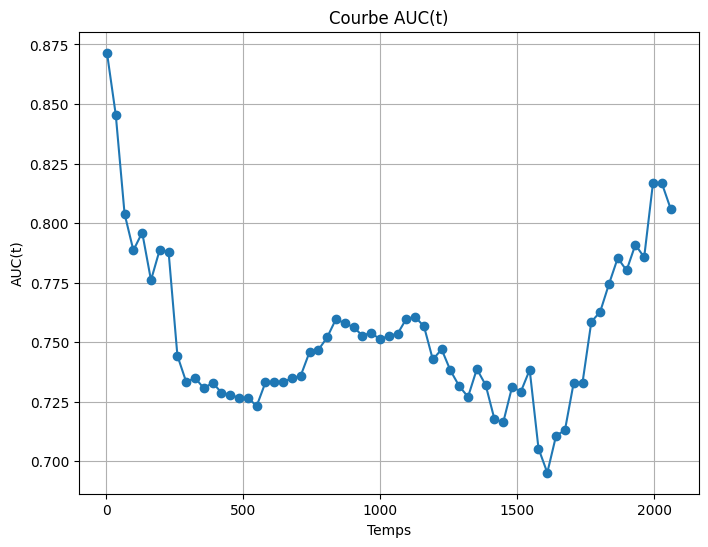

In [ ]:
#Plot
times = np.linspace(2, 2059, 65)
plt.figure(figsize=(8, 6))
plt.plot(times, auc_dynamic[0], marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('AUC(t)')
plt.title('Courbe AUC(t)')
plt.grid(True)
plt.show()

In [ ]:
# Hyperparameters optimization with optuna

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance



def objective(trial):
    # Define search space for hyperparameters
    rsf_params = {
    'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    'max_features' : trial.suggest_categorical('max_features', ["sqrt", "log2"]),

    }

    # Initialize model with hyperparameters
    rsf2 = RandomSurvivalForest(**rsf_params, random_state=42)

    rsf2.fit(X_train , y_train)


    scores = concordance_index_censored(y_test['death'], y_test['time'], rsf2.predict(X_test) )
    c_index_mean = scores[0]

    return c_index_mean


# Create Optuna study object
study = optuna.create_study(direction='maximize')


# Run optimization
study.optimize(objective, n_trials=50)

# Access best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best C-index:", study.best_value)

[I 2024-04-18 13:54:38,674] A new study created in memory with name: no-name-a6576f3a-2f62-4392-8b90-c89c1ca83dc0
[I 2024-04-18 13:54:38,893] Trial 0 finished with value: 0.8319197402219745 and parameters: {'n_estimators': 97, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,215] Trial 1 finished with value: 0.8296903019434886 and parameters: {'n_estimators': 138, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,524] Trial 2 finished with value: 0.8299326321911501 and parameters: {'n_estimators': 141, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8319197402219745.
[I 2024-04-18 13:54:39,866] Trial 3 finished with value: 0.826224979401929 and parameters: {'n_estimators': 141, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. 

Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best C-index: 0.8338826152280328


output of optuna optimisation : 

Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Best C-index: 0.8338826152280328

In [ ]:
# Hyperparameters optimization with a gridsearch approach, we use a gridsearch suggested by the optuna optimization

# Define the gridsearch space
param_grid = {
    'n_estimators': [69, 70, 71],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1,2],
    'max_features': ["sqrt", None]
}
# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt['death'] for elt in y],[elt['time'] for elt in y],estimator.predict(X))[0]
    return concordance

# Initialize the model
best_score = 0
best_params = None

for n_estimators in param_grid['n_estimators']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
          for max_features in param_grid['max_features']:
            # Create model instance with current hyperparameters
            model = RandomSurvivalForest(n_estimators= n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features= max_features, n_jobs=-1, random_state=42)

            def k_fold_cross_validation(model, X, y, k=5):
                """
                Performs k-fold cross-validation for a given model and dataset.

                Parameters:
                    model: The machine learning model to evaluate.
                    X (numpy.ndarray): The feature matrix.
                    y (numpy.ndarray): The target vector.
                    k (int): Number of folds for cross-validation.

                Returns:
                    float: The average accuracy across all folds.
                """
                n = len(X)
                fold_size = n // k
                scores = []

                for i in range(k):
                    # Splitting data into training and validation sets
                    validation_X = X[i * fold_size: (i + 1) * fold_size]
                    validation_y = y[i * fold_size: (i + 1) * fold_size]
                    train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
                    train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

                    # Fitting the model
                    model.fit(train_X, train_y)

                    # Making predictions on the validation set
                    y_pred = model.predict(validation_X)

                    # Calculating accuracy
                    score = scorer(model, validation_X, validation_y)
                    scores.append(score)

                # Returning the average accuracy
                return sum(scores) / k

            if k_fold_cross_validation(model, X_train, y_train, k=5)>best_score:
                best_score = k_fold_cross_validation(model, X_train, y_train, k=5)
                best_params = {'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature nam

Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Score: 0.9070802712890533


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(


output of gridsearch optimisation :

Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

Best Score: 0.8338826152280328

In [23]:
best_params = {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

In [24]:
# Best RSF model

best_rsf = RandomSurvivalForest(**best_params, random_state=42)
best_rsf.fit(X_train, y_train)

# Compute the concordance index
c_index = concordance_index_censored(y_test['death'], y_test['time'], best_rsf.predict(X_test))
print("C-index:", c_index)

C-index: (0.8219599670430863, 16862, 3576, 195, 1057)


In [26]:
# define the concordance index

best_c_index = concordance_index_censored(y_test['death'], y_test['time'], best_rsf.predict(X_test))
print("C-index:", best_c_index)

# define the concordance index ipcw

best_concordance_ipcw = concordance_index_ipcw(y_train, y_test, best_rsf.predict(X_test))
print(f"c_index_ipcw : {best_concordance_ipcw[0]}")

# compute the auc dynamic score

best_auc_dynamic = cumulative_dynamic_auc(y_train, y_test, best_rsf.predict(X_test),times = np.arange(1, 1500, 30))
print(f"auc_dynamic : {best_auc_dynamic[1]}")

# compute the integrated brier score

best_surv = best_rsf.predict_survival_function(X_test, return_array = True)
times2 = np.linspace(2, 2059, 11)
best_ibs = integrated_brier_score(y_train, y_test, best_surv, times2)
print("ibs", best_ibs)


C-index: (0.8219599670430863, 16862, 3576, 195, 1057)
c_index_ipcw : 0.7993913509382502
auc_dynamic : 0.8436774230819152
ibs 0.14387974673355516


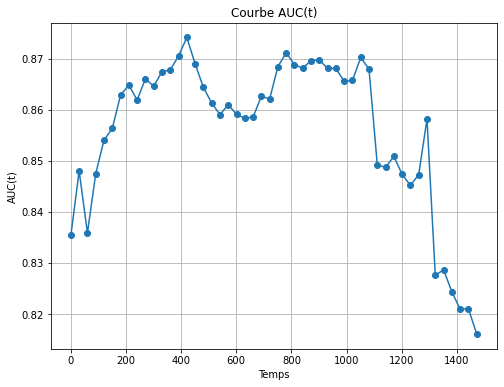

In [27]:
#Auc(t) plot
#Plot
times3 = np.arange(1, 1500, 30)
plt.figure(figsize=(8, 6))
plt.plot(times3, best_auc_dynamic[0], marker='o', linestyle='-')
plt.xlabel('Temps')
plt.ylabel('AUC(t)')
plt.title('Courbe AUC(t)')
plt.grid(True)
plt.show()



In [28]:
#number of people left in the study along time

def remaining(df):

  L = []
  for t in times3:
    remaining_count = (df['time'] > t).sum()  # Count remaining patients
    L.append(remaining_count)
  return L



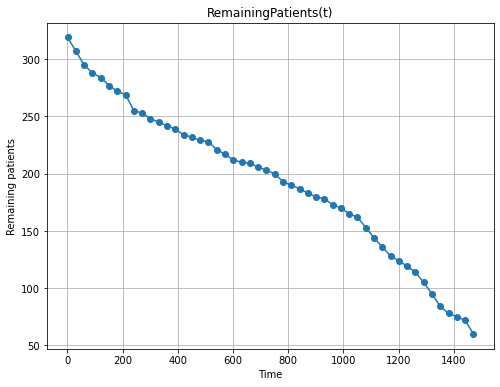

In [36]:
# plot the number of people left in the study along time
plt.figure(figsize=(8, 6))
plt.plot(times3, remaining(rea_final), marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Remaining patients')
plt.title('RemainingPatients(t)')
plt.grid(True)
plt.show()

# **Interpretability methods**

# RVI

In [30]:
feature_importances = best_rsf.feature_importances_

total_importance = np.sum(feature_importances)
importances_percentage = (feature_importances / total_importance) * 100
importances_percentage.sort()
variable_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_percentage)), importances_percentage, tick_label=variable_names)
plt.xlabel('Importance en pourcentage')
plt.ylabel('Variables')
plt.title('Importance des variables')
plt.show()

NotImplementedError: 

# SurvLIME

In [32]:
# define explainer
explainer = SurvLimeExplainer(
    training_features=X_train,
    training_events=[tp[0] for tp in y_train],
    training_times=[tp[1] for tp in y_train],
    model_output_times=best_rsf.event_times_,
    random_state=42,
)

In [33]:
# select instance to explain
instance_index = 0

# explain one instance
b_gb = explainer.explain_instance(
    data_row = X_test.iloc[instance_index].values,
    predict_fn=best_rsf.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)



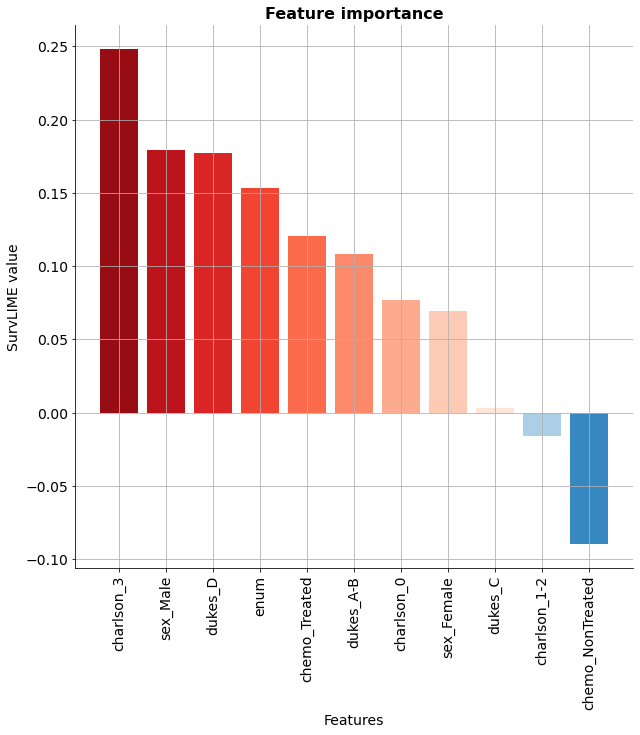

In [34]:
# plot the coefficients of 
explainer.plot_weights()

In [35]:
# create a dictionary that maps the feature names to lime feature coefficient

feature_names = X_train.columns
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = b_gb[i]

feature_dict

{'enum': 0.15300632337525116,
 'sex_Female': 0.06946555615718154,
 'sex_Male': 0.17897063466157062,
 'chemo_NonTreated': -0.08948853261983881,
 'chemo_Treated': 0.12035169623278659,
 'dukes_A-B': 0.10817054615573453,
 'dukes_C': 0.0030060202246677127,
 'dukes_D': 0.17710445571246694,
 'charlson_0': 0.07694249314870429,
 'charlson_1-2': -0.015771837560648587,
 'charlson_3': 0.2478672009394524}

# SHAP

In [ ]:
# Let's use shap method to interpret this model, since the output of a SSVM is a risk score, we can use classical shap method to interpret it

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(best_rsf.predict, X_train)
shap_values = explainer.shap_values(X_test)



  0%|          | 0/323 [00:00<?, ?it/s]

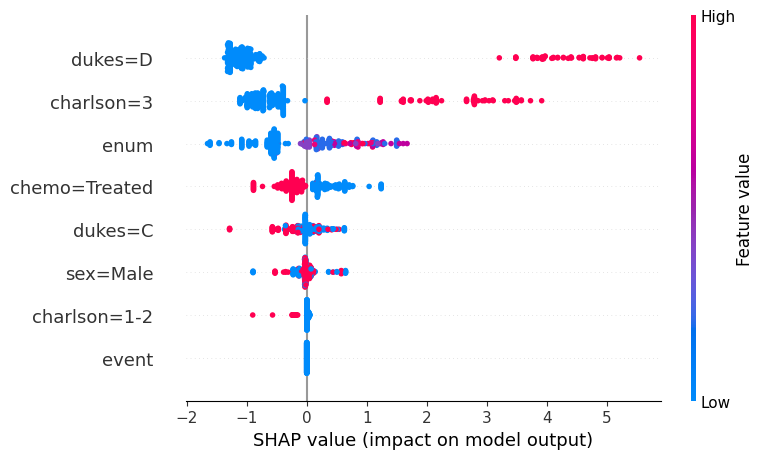

In [ ]:
shap.summary_plot(shap_values,X_test)